# DATASET: High school dynamic contact networks

### Equipe: Natalia Carreras, Pedro Altobelli, Willian Kenzo

## Contexto:

* O dataset escolhido pelo grupo foi retirado do site sociopatterns.orgs, ele contém uma rede temporal de contatos entre estudantes de classes preparatórias em Marseilles, França. 


* Os contatos de alunos foram registrados a partir de 5 classes durante 7 dias em 2012, sendo contabilizado o contato se um aluno está localizado dentro de 1-1.5 metros de distância um do outro por mais de 20 segundos

* Durante nossas análises não iremos contabilizar a quantidade de vezes que cada aluno fez contato com outro, exemplo: se Aluno X conversou com Aluno Y 3 vezes por dia, iremos utilizar apenas contatos únicos, além disso a duração de contato também não utilizaremos.


http://www.sociopatterns.org/datasets/high-school-dynamic-contact-networks/

In [56]:
import netpixi #import das bibliotecas necessárias
from netpixi.integration.gt import *
from regression.integration.gt import *
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

graph = Graph(directed=False) #dirigidonão


## Construção do grafo a partir do dataset

* Formatação do dataset escolhido:  Tempo de contato - ID1 - ID2 - Class1 - Class2



In [46]:
with open('thiers_2012.csv', "r") as arquivo:
    csv_lines = arquivo.readlines()
print("Exemplo de dados por linha: ",csv_lines[0])

vertex = []
edge = []

for line in csv_lines:
    split = line.split()
    time = split[0]
    id1 = split[1]
    id2 = split[2]
    class1 = split[3]
    class2 = split[4]
    
    if id1 not in vertex:
        vertex.append(id1)
        graph.add_vertex(id1)
        u = graph.get_vertex(id1)
        graph.add_vp('class')
        u['class'] = class1
    
    if id2 not in vertex:
        graph.add_vertex(id2)
        vertex.append(id2)
        u = graph.get_vertex(id2)
        graph.add_vp('class')
        u['class'] = class2        
        
    if [id1,id2] not in edge:
        edge.append([id1,id2])
        edge.append([id2,id1])#ver jeito melhor
        graph.add_edge(id1,id2)
        

Exemplo de dados por linha:  1353303380	1170	1644	MP*1	MP*1



* O nosso dataset também tem um txt com o gênero de cada aluno(ID), então também foi adicionado como propriedade de vértice os gêneros.

In [47]:
with open('metadata_212.txt', "r") as arquivo:
    data_lines = arquivo.readlines()

for line in data_lines:
    split = line.split()
    student_id = split[0]
    gender = split[2]
    
    u = graph.get_vertex(student_id)
    graph.add_vp('gender')
    u['gender'] = gender
    
gt_save(graph, '2012_class_gender.net.gz')        

In [48]:
r = netpixi.render('2012_class_gender.net.gz')

## Análise exploratória

* Número de vértices, número de arestas e densidade
* Estatísticas

In [49]:
print('Número de vértices(ALunos):', graph.num_vertices())
print('Número de arestas(Contatos durante a semana):', graph.num_edges())

Número de vértices(ALunos): 180
Número de arestas(Contatos durante a semana): 2220


* Todos os vértices tem sua classe e genero como propriedade

In [50]:
data = gt_data(graph)
data

,class,gender
id,,
1170,MP*1,M
1644,MP*1,M
1613,MP*1,M
1181,MP*1,M
1651,MP*1,M
...,...,...
666,PC,M
881,PC*,M
607,PC,M


## Degrees

Por ser um grafo não direcionado, existe apenas o degree, que significa para nosso dataset a quantidade de contatos que cada aluno teve durante a semana

In [51]:
degrees = []
for v in graph.all_vertices():
    degrees.append(v.total_degree()) 
    
data['degree'] = degrees
media_degree = data['degree'].mean()
data

,class,gender,degree
id,,,
1170,MP*1,M,36
1644,MP*1,M,33
1613,MP*1,M,37
1181,MP*1,M,32
1651,MP*1,M,29
...,...,...,...
666,PC,M,27
881,PC*,M,8
607,PC,M,11


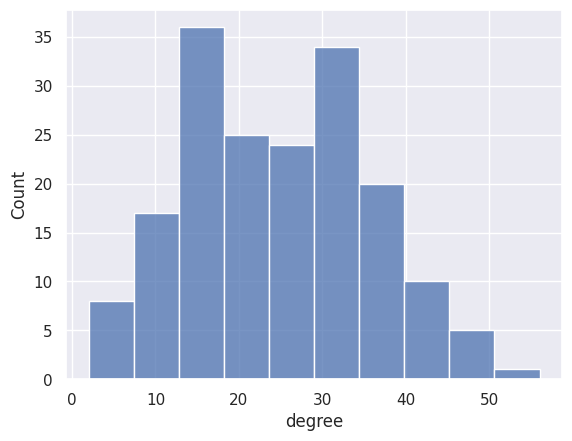

In [57]:
sns.histplot(data['degree'])
data['degree'].describe()

plt.savefig('describe.png')

In [ ]:
print('Média de contatos dos alunos: ',media_degree)

<AxesSubplot: xlabel='class', ylabel='count'>

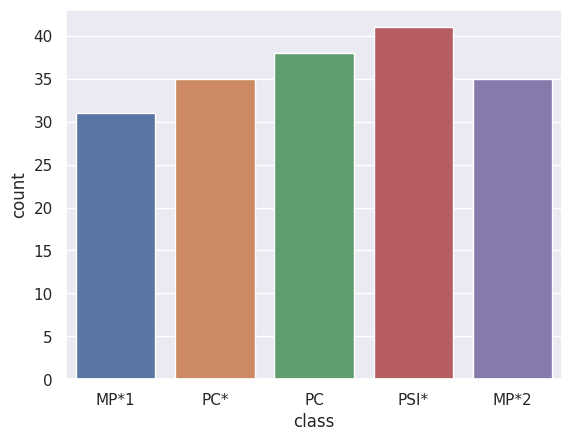

In [36]:
data = gt_data(graph)
data['class'].value_counts()
sns.countplot(x=data["class"])

* As salas dos alunos são dividas em PC(Física e Química), MP(Matemática e Física) e PSI(Estudos de engenharia) e o asterisco (\*) indica sala diferente do mesmo curso. Exemplo: COMPA, COMPB

* Nota-se que as classes são focadas na área de exatas

<AxesSubplot: xlabel='gender', ylabel='count'>

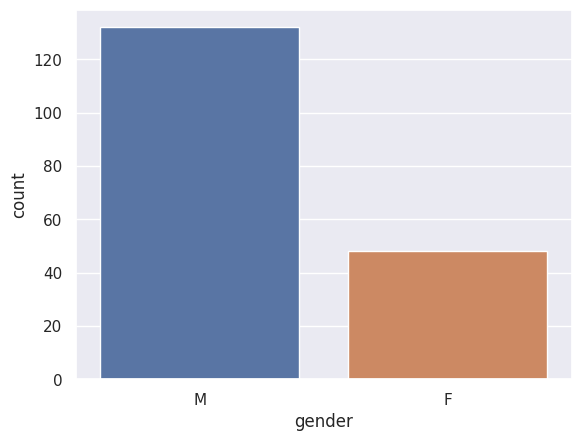

In [37]:
sns.countplot(x=data["gender"])

* Cerca de 73% dos alunos no nosso dataset é masculino, provavelmente o motivo seja as classes sendo focadas em conteúdos de exatas, o que tem uma maioridade de homens

## Análise visual

* Utilizar um algoritmo baseado em force-directed graph drawing, para evidenciar grupos para analises
* Deixar o grafo mais visível com o que pretendemos analsiar no momento


O algoritmo escolhido para analisar será o ARF que ajuda a evidenciar clusters

In [38]:
g = gt_load('2012_class_gender.net.gz')
m = gt_draw.arf_layout(g)
gt_move(g, m)
gt_save(g, 'arf.net.gz')
netpixi.render('arf.net.gz');

Nota-se no grafo acima 4 grupos distintos, mas ainda não consegue-se obter mais informações sobre cada cluster em si, então para isso criaremos uma função que pode evidenciar as propriedades de cada vértice no grafo

In [39]:
pretty = netpixi.render('arf.net.gz');

def set_label_set_property(prop,label):
    
    for v in g.all_vertices(): 
        ver = v[prop]
        id_v = v.get_id()
        val_cor = 0xffffff
        if prop == 'class':
            if ver == "MP*1":
                val_cor = 0xffd700
            elif ver == "PC":
                val_cor = 0x00ff00
            elif ver == "PSI*":
                val_cor = 0xE69138
            elif ver == "PC*":
                val_cor = 0x6AA84F
            elif ver == "MP*2":
                val_cor = 0x993399
            else:
                print("outro")
        elif prop == 'gender':
            if ver == "M":
                val_cor = 0x0000ff
            elif ver == "F":
                val_cor = 0xFF00D7
            else:
                print("outro")
        
        pretty.vertex(id_v, color=val_cor)
        pretty.vertex_set_key(label)
    return None


A função set_label_set_property() pode ser utilizada para analisar o grafo com métricas diferentes, como se gênero influenciam nos clusters baseado

In [41]:
set_label_set_property('class','class')
#É possível apenas tirar o comentário das linhas de baixo para analisar outras propriedades dos vértices
# set_label_set_property('gender','gender')
# set_label_set_property('gender','class')
# set_label_set_property('class','gender')

Agora podemos notar que os clusters estão muito relacionados a sala em que cada aluno está e também notamos que o cluster que junta duas salas diferentes (MP1 e MP2) ainda sim tem a mesmas similaridades de classe